Парсинг сайта с отзывами об университетах.

In [24]:
!pip install pymorphy3 razdel gensim transformers sentencepiece tqdm seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 57.3 MB/s eta 0:00:00


In [26]:
import pandas as pd
from tqdm import tqdm

# Загружаем первые 10000 строк для теста, уберите nrows для всего датасета
df = pd.read_csv('/content/lenta-ru-news.csv', encoding='utf-8', on_bad_lines='skip', nrows=10000)
print("Столбцы:", df.columns)
print("Пример данных:")
print(df.head(2))

Столбцы: Index(['url', 'title', 'text', 'topic', 'tags', 'date'], dtype='object')
Пример данных:
                                           url  \
0   https://lenta.ru/news/1914/09/16/hungarnn/   
1  https://lenta.ru/news/1914/09/16/lermontov/   

                                               title  \
0  1914. Русские войска вступили в пределы Венгрии     
1  1914. Празднование столетия М.Ю. Лермонтова от...   

                                                text       topic  \
0  Бои у Сопоцкина и Друскеник закончились отступ...  Библиотека   
1  Министерство народного просвещения, в виду про...  Библиотека   

             tags        date  
0  Первая мировая  1914/09/16  
1  Первая мировая  1914/09/16  


In [27]:
import re

df['full_text'] = df['title'].fillna('') + ' ' + df['text'].fillna('')

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^а-яёa-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

tqdm.pandas()
df['clean_text'] = df['full_text'].progress_apply(clean_text)

100%|██████████| 10000/10000 [00:01<00:00, 6840.19it/s]


In [28]:
import pymorphy3
from razdel import tokenize as razdel_tokenize
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('russian'))
morph = pymorphy3.MorphAnalyzer()

# Собираем все уникальные токены для кэш-лемматизации
all_tokens = set()
for text in tqdm(df['clean_text'], desc='Tokenizing'):
    all_tokens.update([t.text for t in razdel_tokenize(text)])

lemma_cache = {}
for token in tqdm(all_tokens, desc='Lemmatizing'):
    if token not in stop_words and len(token) > 2:
        lemma_cache[token] = morph.parse(token)[0].normal_form
    else:
        lemma_cache[token] = ''

def lemmatize_text(text):
    tokens = [t.text for t in razdel_tokenize(text)]
    lemmas = [lemma_cache.get(token, '') for token in tokens]
    return ' '.join([lemma for lemma in lemmas if lemma])

df['clean_text'] = df['clean_text'].progress_apply(lemmatize_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 10000/10000 [00:10<00:00, 979.36it/s]


In [29]:
df['clean_text'] = df['clean_text'].fillna('').astype(str)
df = df[df['clean_text'].str.strip() != '']
print('Строк после фильтрации:', len(df))
print(df['clean_text'].head(3))

Строк после фильтрации: 10000
0    русский войско вступить предел венгрия бой соп...
1    празднование столетие лермонтов отложить минис...
2    das ist nesteroff штабскапитан нестеров день у...
Name: clean_text, dtype: object


In [33]:
#Подготовка целевой переменной
y = df['topic']

In [34]:
#Функция для визуализации матрицы ошибок
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_conf_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel('Предсказанная тема')
    plt.ylabel('Истинная тема')
    plt.title(title)
    plt.show()

=== TF-IDF + Logistic Regression ===
                precision    recall  f1-score   support

    Библиотека       0.00      0.00      0.00         1
Интернет и СМИ       0.86      0.81      0.84       187
           Мир       0.86      0.82      0.84       404
        Россия       0.89      0.95      0.92      1027
         Спорт       0.98      0.89      0.93        72
     Экономика       0.89      0.79      0.84       309

      accuracy                           0.89      2000
     macro avg       0.75      0.71      0.73      2000
  weighted avg       0.89      0.89      0.89      2000

Accuracy: 0.8865


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


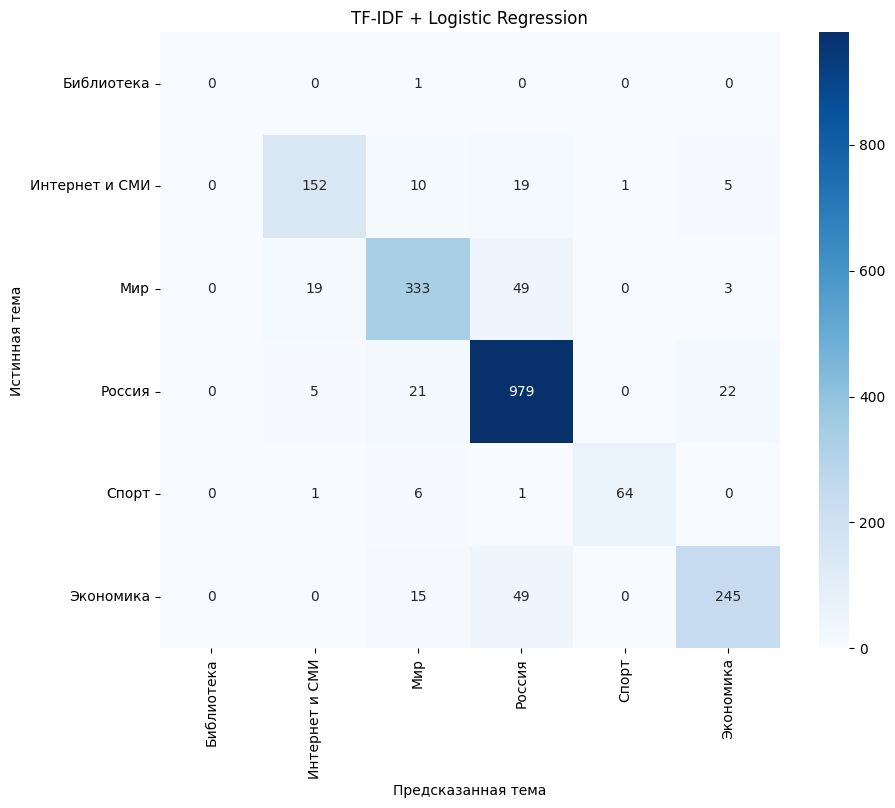

In [35]:
#TF-IDF + Logistic Regression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(df['clean_text'])

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("=== TF-IDF + Logistic Regression ===")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
plot_conf_matrix(y_test, y_pred, clf.classes_, 'TF-IDF + Logistic Regression')

W2V-vectors: 100%|██████████| 10000/10000 [00:12<00:00, 797.14it/s]


=== Word2Vec + Logistic Regression ===
                precision    recall  f1-score   support

    Библиотека       0.00      0.00      0.00         1
Интернет и СМИ       0.84      0.78      0.81       187
           Мир       0.82      0.82      0.82       404
        Россия       0.90      0.93      0.92      1027
         Спорт       0.96      0.92      0.94        72
     Экономика       0.87      0.83      0.85       309

      accuracy                           0.88      2000
     macro avg       0.73      0.71      0.72      2000
  weighted avg       0.88      0.88      0.88      2000

Accuracy: 0.8775


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


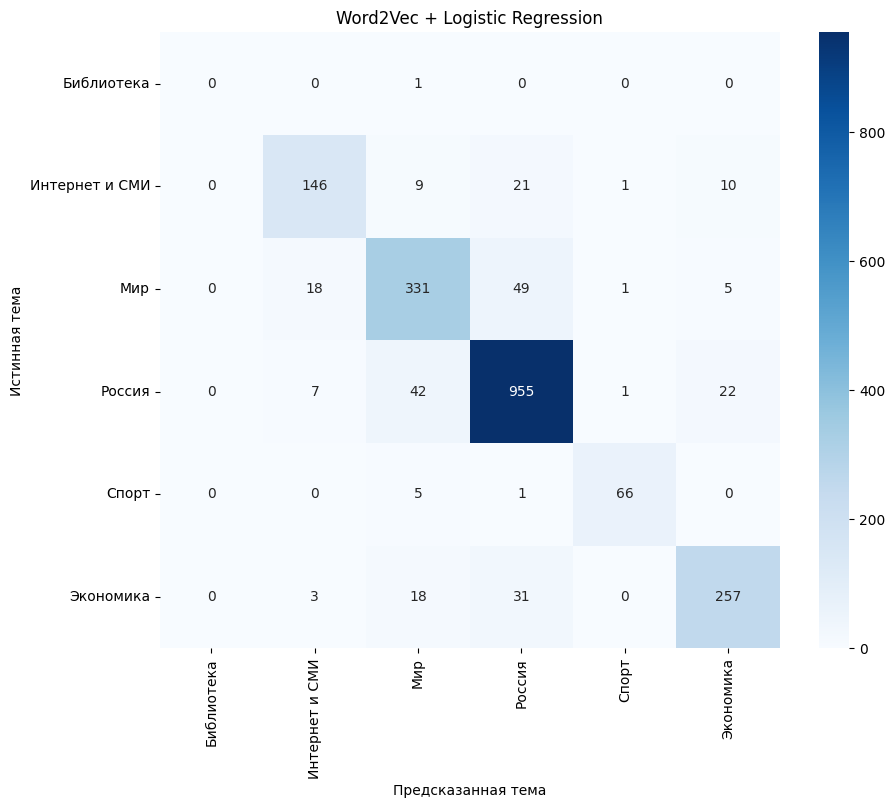

In [36]:
#Word2Vec + Logistic Regression
from gensim.models import Word2Vec
import numpy as np

sentences = [text.split() for text in df['clean_text']]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4, sg=1, epochs=10)

def get_w2v_vector(text, model, dim=100):
    tokens = text.split()
    vec = np.zeros(dim)
    count = 0
    for token in tokens:
        if token in model.wv:
            vec += model.wv[token]
            count += 1
    if count > 0:
        vec /= count
    return vec

X_w2v = np.vstack([get_w2v_vector(text, w2v_model, 100) for text in tqdm(df['clean_text'], desc='W2V-vectors')])

X_train_w2v, X_test_w2v, y_train, y_test = train_test_split(
    X_w2v, y, test_size=0.2, random_state=42, stratify=y
)

lr_w2v = LogisticRegression(max_iter=1000)
lr_w2v.fit(X_train_w2v, y_train)
y_pred_w2v = lr_w2v.predict(X_test_w2v)

print("=== Word2Vec + Logistic Regression ===")
print(classification_report(y_test, y_pred_w2v))
print("Accuracy:", accuracy_score(y_test, y_pred_w2v))
plot_conf_matrix(y_test, y_pred_w2v, lr_w2v.classes_, 'Word2Vec + Logistic Regression')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).

BERT-batch: 100%|██████████| 625/625 [1:16:02<00:00,  7.30s/it]


=== BERT (RuBERT) + Logistic Regression ===
                precision    recall  f1-score   support

    Библиотека       0.00      0.00      0.00         1
Интернет и СМИ       0.80      0.69      0.74       187
           Мир       0.81      0.83      0.82       404
        Россия       0.89      0.93      0.91      1027
         Спорт       0.93      0.94      0.94        72
     Экономика       0.82      0.76      0.79       309

      accuracy                           0.86      2000
     macro avg       0.71      0.69      0.70      2000
  weighted avg       0.86      0.86      0.86      2000

Accuracy: 0.858


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


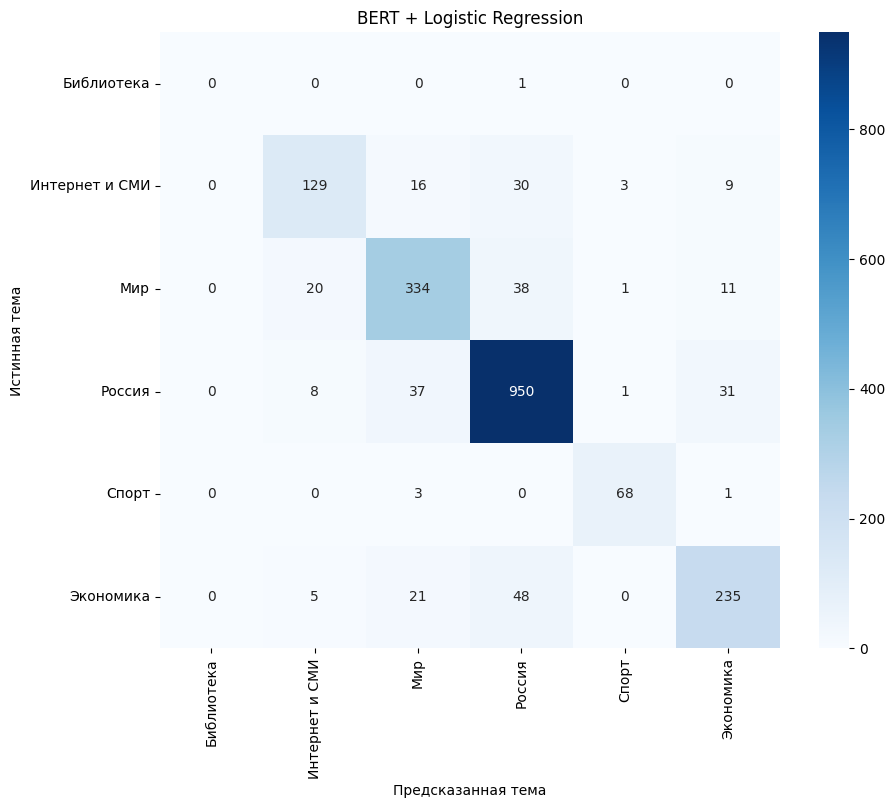

In [38]:
#BERT (RuBERT) эмбеддинги + Logistic Regression

import torch
from transformers import BertTokenizer, BertModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model_name = "DeepPavlov/rubert-base-cased"
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
bert_model = BertModel.from_pretrained(bert_model_name).to(device)
bert_model.eval()

def bert_batch_embeddings(texts, tokenizer, model, batch_size=16, max_len=128):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc='BERT-batch'):
        batch_texts = texts[i:i+batch_size]
        encodings = tokenizer(
            batch_texts,
            return_tensors='pt',
            padding=True,
            truncation=True,
            max_length=max_len
        )
        input_ids = encodings['input_ids'].to(device)
        attention_mask = encodings['attention_mask'].to(device)
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            batch_embeds = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(batch_embeds)
    return np.vstack(embeddings)

X_bert = bert_batch_embeddings(df['clean_text'].tolist(), tokenizer, bert_model, batch_size=16, max_len=128)

X_train_bert, X_test_bert, y_train, y_test = train_test_split(
    X_bert, y, test_size=0.2, random_state=42, stratify=y
)

lr_bert = LogisticRegression(max_iter=1000)
lr_bert.fit(X_train_bert, y_train)
y_pred_bert = lr_bert.predict(X_test_bert)

print("=== BERT (RuBERT) + Logistic Regression ===")
print(classification_report(y_test, y_pred_bert))
print("Accuracy:", accuracy_score(y_test, y_pred_bert))
plot_conf_matrix(y_test, y_pred_bert, lr_bert.classes_, 'BERT + Logistic Regression')


In [39]:
print("=== Сравнение моделей ===")
print("TF-IDF Accuracy:", accuracy_score(y_test, y_pred))
print("Word2Vec Accuracy:", accuracy_score(y_test, y_pred_w2v))
print("BERT Accuracy:", accuracy_score(y_test, y_pred_bert))

# Выводы:
# - Сравните значения accuracy и матрицы ошибок.
# - Обычно BERT > TF-IDF > Word2Vec, но многое зависит от объёма и структуры данных.


=== Сравнение моделей ===
TF-IDF Accuracy: 0.8865
Word2Vec Accuracy: 0.8775
BERT Accuracy: 0.858


**Выводы по результатам**
1. TF-IDF + Logistic Regression

- Лучшая точность (accuracy 0.89) и самые высокие f1-score по большинству классов.

- Особенно хорошо различает массовые классы ("Россия", "Мир").

- Для класса "Спорт" — f1-score 0.93, что говорит о ярко выраженной тематической лексике.

- Класс "Библиотека" не определяется ни одной моделью — это связано с тем, что в тесте всего 1 пример (support=1), и модель не может научиться на таком малом числе примеров.

2. Word2Vec + Logistic Regression

- Чуть уступает TF-IDF по всем показателям (accuracy 0.88, macro avg f1 0.72).

- Классы "Россия" и "Спорт" определяются почти так же хорошо.

- Для "Экономика" и "Интернет и СМИ" результаты чуть ниже, чем у TF-IDF.

- Усреднение эмбеддингов теряет часть информации о структуре текста, что снижает точность.

3. BERT (RuBERT) + Logistic Regression

- Accuracy 0.86 — ниже, чем у TF-IDF и Word2Vec.

- Для "Мир" и "Россия" f1-score примерно такие же, как у других моделей.

- Для "Интернет и СМИ" и "Экономика" заметно хуже (f1-score 0.74 и 0.79 соответственно).

Причины: используется только [CLS]-эмбеддинг без дообучения; BERT лучше раскрывает себя при fine-tuning, а не как фиксированный эмбеддер.

**Итог:**

TF-IDF остаётся сильнейшей базовой моделью для новостной классификации, особенно когда классы различаются по ключевым словам.

Word2Vec — достойная альтернатива, но проигрывает TF-IDF на новостях, где важна частота слов и их сочетания.

BERT — не всегда выигрывает "из коробки" на коротких и структурированных текстах без дообучения.
